<a href="https://colab.research.google.com/github/mohitsethi/100days/blob/master/TargetCaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import os
import zipfile
import random
import glob
import cv2

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from sklearn.model_selection import train_test_split
from google.colab import files

# Load Data

Upload the dataset zip folder as it is.

In [ ]:
#@title Select zip file

zip_file = files.upload()
zip_file = list(zip_file.keys())[0]

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()

os.listdir('/content/yolo_format')

Saving dataset_MaskDetection.zip to dataset_MaskDetection.zip


['mask_with_coodinate', 'normal_with_coodinate']

# Visualization

## Display few images

In [ ]:
masked_imgs = sorted(glob.glob('/content/yolo_format/mask_with_coodinate/*.jpg'))
normal_imgs = sorted(glob.glob('/content/yolo_format/normal_with_coodinate/*.jpg'))
masked_txt = sorted(glob.glob('/content/yolo_format/mask_with_coodinate/*.txt'))
normal_txt = sorted(glob.glob('/content/yolo_format/normal_with_coodinate/*.txt'))

print('Total masked images:', len(masked_imgs))
print('Total normal images:', len(normal_imgs))
print('Total masked text:', len(masked_txt))
print('Total normal text:', len(normal_txt))

Total masked images: 201
Total normal images: 100
Total masked text: 201
Total normal text: 100


In [ ]:
DISPLAY_IMAGES = 5

def plt_sample_images(dataset):
  img_samples = random.sample(dataset, DISPLAY_IMAGES)

  plt.figure(figsize=(10, DISPLAY_IMAGES))
  for index, file_path in enumerate(img_samples, 1):
    img = mpimg.imread(file_path)
    plt.subplot(1, DISPLAY_IMAGES, index)
    plt.axis('off')
    plt.imshow(img)
  plt.show()

### Masked images sample

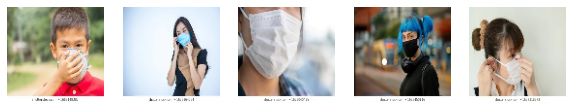

In [ ]:
plt_sample_images(masked_imgs)

### Normal images sample

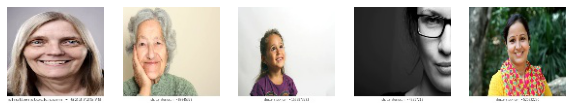

In [ ]:
plt_sample_images(normal_imgs)

## Display images with bounding boxes

In [ ]:
def plt_sample_images_with_bb(images, boxes):
  indexes = random.sample(list(range(len(images))), DISPLAY_IMAGES)
  img_samples = [images[i] for i in indexes]
  txt_samples = [boxes[i] for i in indexes]

  plt.figure(figsize=(10, DISPLAY_IMAGES))
  for index, (file_path, txt_path) in enumerate(zip(img_samples, txt_samples), 1):
    img = mpimg.imread(file_path)

    with open(txt_path, 'r') as fid:
      bb = fid.readline()
      bb = [int(float(i)) for i in bb.split()[1:]]

    cv2.rectangle(img, (bb[0], bb[1]), (bb[0] + bb[2], bb[1] + bb[3]), (255, 0, 0))
    plt.subplot(1, DISPLAY_IMAGES, index)
    plt.axis('off')
    plt.imshow(img)
  plt.show()

### Masked images sample

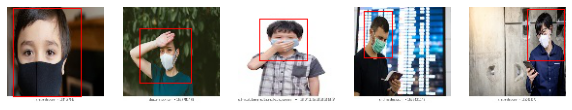

In [ ]:
plt_sample_images_with_bb(masked_imgs, masked_txt)

### Normal images sample

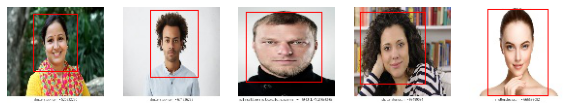

In [ ]:
plt_sample_images_with_bb(normal_imgs, normal_txt)

# Exploratory Data Analysis

Check if all the images have only one bounding box

In [ ]:
def is_only_one_bb(folder_path):
  text_files = glob.glob(folder_path + '/*.txt')
  for text_file in text_files:
    with open(text_file, 'r') as fid:
      text = fid.read().split('\n')
      if len(text) != 1:
        print(text_file, 'has', len(text), 'lines')

In [ ]:
is_only_one_bb('/content/yolo_format/mask_with_coodinate')
is_only_one_bb('/content/yolo_format/normal_with_coodinate')

**Conclusion:** All files have only one bounding box. We will take advantage of this fact.

Based on initial raw inspection, the image files are of same size at 100 x 100. Let us thoroughly check if all the files are of same size.

In [ ]:
def is_image_size_fixed(folder_path):
  img_files = glob.glob(folder_path + '/*.jpg')
  for img_file in img_files:
      img = mpimg.imread(img_file)
      if img.shape[0] != 100 or img.shape[1] != 100:
        print(img_file, 'has different shape') 

In [ ]:
is_image_size_fixed('/content/yolo_format/mask_with_coodinate')
is_image_size_fixed('/content/yolo_format/normal_with_coodinate')

**Conclusion:** All files have a fixed size of 100 x 100. We will take advantage of this fact.

# Data Pipeline

In [ ]:
class Data:
  def __init__(self, params):
    self._img_size = params['IMG_SIZE']
    self._resize_factor = (1.0 * params['IMG_SIZE'][0] / 100.0, 
                           1.0 * params['IMG_SIZE'][1] / 100.0)

    train_data, val_data = self._prepare_data(params['MASKED_FOLDER'], 
                                              params['NORMAL_FOLDER'], 
                                              params['TRAIN_VAL_RATIO'])
    
    batch_size = params['BATCH_SIZE']
    self.train_ds = self._prepare_pipeline(train_data, batch_size, True)
    self.val_ds = self._prepare_pipeline(val_data, batch_size, False)

  def _prepare_data(self, masked_folder, normal_folder, train_size):
    masked_fp, masked_bb, masked_labels = self._read_folder_data(masked_folder)
    normal_fp, normal_bb, normal_labels = self._read_folder_data(normal_folder)

    img_fp = masked_fp + normal_fp
    bb = masked_bb + normal_bb
    labels = masked_labels + normal_labels
    
    train_img, val_img, train_bb, val_bb, train_labels, val_labels = train_test_split(img_fp, bb, labels, 
                            train_size=train_size, shuffle=True, stratify=labels)
    train_data = (train_img, train_bb, train_labels)
    val_data = (val_img, val_bb, val_labels)
    return train_data, val_data

  def _read_folder_data(self, folder_path):
    imgs_fp = sorted(glob.glob(os.path.join(folder_path, '*.jpg')))
    text_fp = sorted(glob.glob(os.path.join(folder_path, '*.txt')))

    bb_arr, labels = [], []
    for txt in text_fp:
      with open(txt, 'r') as fid:
        txt_line = fid.read().split()
        labels.append(int(txt_line[0]))
        bb = [float(i) / 100.0 for i in txt_line[1:]]
        bb[2] += bb[0]
        bb[3] += bb[1]
        
        bb[0] *= self._resize_factor[0]
        bb[1] *= self._resize_factor[1]
        bb[2] *= self._resize_factor[0]
        bb[3] *= self._resize_factor[1]
        
        bb_arr.append(bb)
    return imgs_fp, bb_arr, labels

  def _prepare_pipeline(self, data, batch_size, shuffle):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.map(self._read_img)
    if shuffle:
      ds = ds.shuffle(256)
      ds = ds.map(self._augment_img)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

  def _read_img(self, img_fp, bb, label):
    img = tf.io.read_file(img_fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, self._img_size)
    img /= 255.0
    img -= 0.5

    return img, {'classifier':label, 'localizer': bb}

  def _augment_img(self, img, output):
    if random.choices([True, False], weights=[0.3, 0.7]):
      img = tf.image.random_brightness(img, 0.2)  
    elif random.choices([True, False], weights=[0.3, 0.7]):
      img = tf.image.random_contrast(img, 0.2, 0.5)

    return img, output

In [ ]:
params = {
    'MASKED_FOLDER': '/content/yolo_format/mask_with_coodinate',
    'NORMAL_FOLDER': '/content/yolo_format/normal_with_coodinate',
    'TRAIN_VAL_RATIO': 0.9,
    'BATCH_SIZE': 64,
    'IMG_SIZE': [96, 96]
}

d = Data(params)

for img, output in d.train_ds.take(1):
  print(img.shape, output['localizer'].shape, output['classifier'].shape)
  print(output['localizer'][:3])
  print(output['classifier'][:3])

(64, 96, 96, 3) (64, 4) (64,)
tf.Tensor(
[[0.1728 0.1632 0.6816 0.5184]
 [0.3264 0.0384 0.5376 0.288 ]
 [0.4608 0.1632 0.7968 0.7296]], shape=(3, 4), dtype=float32)
tf.Tensor([0 0 0], shape=(3,), dtype=int32)


# Create Model

In [ ]:
class Model:
  def __init__(self, params=None, load_path=None):
    if params is not None:
      self._save_path = params['SAVE_PATH']
      self.network = self._build_model(params['HUB_URL'], params['IMG_SIZE'])
    elif load_path is not None:
      self.network = self._load_model(load_path)

  def _build_model(self, hub_url, img_size):
    input_layer = tf.keras.Input(shape=img_size + [3,])
    hidden = hub.KerasLayer(hub_url, trainable=False)(input_layer)
    classifier = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(hidden)
    localizer = tf.keras.layers.Dense(4, activation='sigmoid', name='localizer')(hidden)

    network = tf.keras.Model(inputs=input_layer, outputs=[classifier, localizer])
    return network
    
  def _load_model(self, load_path):
    network = tf.keras.models.load_model(load_path)
    return network

  def display_model_summary(self):
    self.network.summary()

    tf.keras.utils.plot_model(self.network, to_file='model.png', show_shapes=True)
    sum_img = mpimg.imread('model.png')
    plt.figure(figsize=(14, 14))
    plt.imshow(sum_img)
    plt.show()
    
  def save_model(self):
    self.network.save(self._save_path, include_optimizer=False)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 1280)         2257984     input_1[0][0]                    
__________________________________________________________________________________________________
classifier (Dense)              (None, 1)            1281        keras_layer[0][0]                
__________________________________________________________________________________________________
localizer (Dense)               (None, 4)            5124        keras_layer[0][0]                
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_______

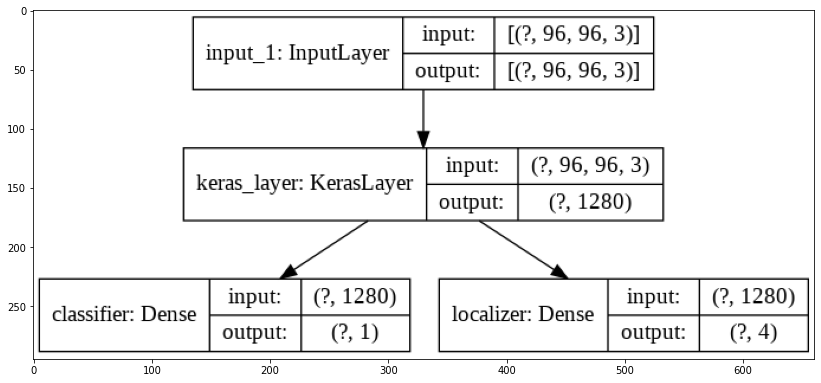

In [ ]:
params = {
    'HUB_URL': 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/4',
    'IMG_SIZE': [96, 96],
    'SAVE_PATH': 'model.h5'
}

m = Model(params=params)
m.display_model_summary()

# Train Model

In [ ]:
class EvalCallback(tf.keras.callbacks.Callback):
  def __init__(self, train_ds, val_ds):
    super(tf.keras.callbacks.Callback, self).__init__()
    self._train_ds = train_ds
    self._val_ds = val_ds

  def on_epoch_end(self, epoch, logs=None):
    if (epoch + 1) % 10 != 0:
      return

    print('Train dataset:')
    self._plot_on_data(self._train_ds)
    
    print('\nVal dataset:')
    self._plot_on_data(self._val_ds)

  def _plot_on_data(self, ds):
    for batch_img, output in ds.take(1):
      pred_label, pred_bb = self.model.predict(batch_img)
      samples = random.sample(list(range(len(batch_img))), DISPLAY_IMAGES)

      plt.figure(figsize=(10, 5))
      for index, sample in enumerate(samples, 1):
        img = batch_img[sample].numpy() + 0.5
        img = (img * 255).astype(np.uint8)
        pred_img_bb, correct_bb = pred_bb[sample], output['localizer'][sample]
        pred_img_bb = [int(i * 100) for i in pred_img_bb]
        correct_bb = [int(i * 100) for i in correct_bb]
        
        cv2.rectangle(img, (correct_bb[0], correct_bb[1]),
                      (correct_bb[2], correct_bb[3]), (0, 255, 0))
        cv2.rectangle(img, (pred_img_bb[0], pred_img_bb[1]),
                      (pred_img_bb[2], pred_img_bb[3]), (0, 0, 255))
        
        plt.subplot(1, DISPLAY_IMAGES, index)
        plt.imshow(img)
        plt.axis('off')
      plt.show()

      for sample in samples:
        print('Actual =', output['classifier'][sample].numpy(),
              ', Predicted = ', int(pred_label[sample][0] + 0.5))

In [ ]:
class Train:
  def __init__(self, params):
    self._epochs = params['EPOCHS']

    self._model = Model(params=params)
    self._data = Data(params)

    self._model.network.compile(optimizer='adam', 
                                loss={'classifier': 'binary_crossentropy', 'localizer': self._localizer_loss},
                                metrics={'classifier': 'acc', 'localizer': self._localizer_metric})

  def _localizer_loss(self, actual, predicted):
    a0, a1, a2, a3 = tf.split(actual, num_or_size_splits=4, axis=1)
    p0, p1, p2, p3 = tf.split(predicted, num_or_size_splits=4, axis=1)

    c0 = tf.math.maximum(a0, p0)
    c1 = tf.math.maximum(a1, p1)
    c2 = tf.math.minimum(a2, p2)
    c3 = tf.math.minimum(a3, p3)
    
    cw = tf.math.maximum(0.0, c2 - c0)
    ch = tf.math.maximum(0.0, c3 - c1)
    common_area = cw * ch
    actual_area = (a2 - a0) * (a3 - a1)

    pw = tf.math.maximum(0.0, p2 - p0)
    ph = tf.math.maximum(0.0, p3 - p1)
    predicted_area = pw * ph
    
    base_area = actual_area + predicted_area - common_area + 1e-7
    loss_val = 1.0 - (common_area / base_area)

    return tf.reduce_mean(loss_val) 

  def _localizer_metric(self, actual, predicted):
    return 1.0 - self._localizer_loss(actual, predicted)
    
  def train(self):
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_classifier_loss',
                          patience=5, verbose=1, mode='min', restore_best_weights=True)
    eval_callback = EvalCallback(self._data.train_ds, self._data.val_ds)
    history = self._model.network.fit(self._data.train_ds, epochs=self._epochs,
                          validation_data=self._data.val_ds,
                          callbacks=[earlystopping_callback, eval_callback],
                          verbose=2)
    print(history.history.keys())
    self._model.save_model()
    return history.history

Epoch 1/100
5/5 - 2s - loss: 1.5936 - classifier_loss: 0.7283 - localizer_loss: 0.8653 - classifier_acc: 0.5630 - localizer__localizer_metric: 0.1525 - val_loss: 1.2820 - val_classifier_loss: 0.6330 - val_localizer_loss: 0.6490 - val_classifier_acc: 0.7419 - val_localizer__localizer_metric: 0.3510
Epoch 2/100
5/5 - 1s - loss: 1.2390 - classifier_loss: 0.5842 - localizer_loss: 0.6548 - classifier_acc: 0.6778 - localizer__localizer_metric: 0.3471 - val_loss: 1.1661 - val_classifier_loss: 0.5239 - val_localizer_loss: 0.6422 - val_classifier_acc: 0.7419 - val_localizer__localizer_metric: 0.3578
Epoch 3/100
5/5 - 1s - loss: 1.0656 - classifier_loss: 0.4388 - localizer_loss: 0.6267 - classifier_acc: 0.7963 - localizer__localizer_metric: 0.3747 - val_loss: 1.0891 - val_classifier_loss: 0.4698 - val_localizer_loss: 0.6193 - val_classifier_acc: 0.8065 - val_localizer__localizer_metric: 0.3807
Epoch 4/100
5/5 - 1s - loss: 0.9797 - classifier_loss: 0.3710 - localizer_loss: 0.6087 - classifier_acc

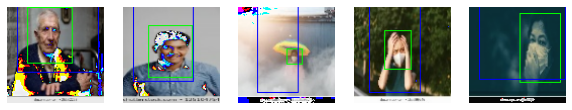

Actual = 1 , Predicted =  1
Actual = 1 , Predicted =  1
Actual = 0 , Predicted =  0
Actual = 0 , Predicted =  0
Actual = 0 , Predicted =  0

Val dataset:


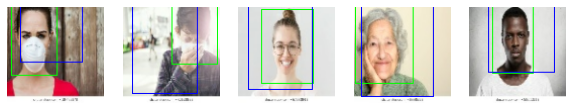

Actual = 0 , Predicted =  0
Actual = 0 , Predicted =  0
Actual = 1 , Predicted =  1
Actual = 1 , Predicted =  1
Actual = 1 , Predicted =  0
5/5 - 4s - loss: 0.7135 - classifier_loss: 0.1714 - localizer_loss: 0.5421 - classifier_acc: 0.9593 - localizer__localizer_metric: 0.4633 - val_loss: 0.9537 - val_classifier_loss: 0.3532 - val_localizer_loss: 0.6006 - val_classifier_acc: 0.8065 - val_localizer__localizer_metric: 0.3994
Epoch 11/100
5/5 - 1s - loss: 0.7024 - classifier_loss: 0.1686 - localizer_loss: 0.5338 - classifier_acc: 0.9556 - localizer__localizer_metric: 0.4703 - val_loss: 0.9536 - val_classifier_loss: 0.3664 - val_localizer_loss: 0.5871 - val_classifier_acc: 0.8065 - val_localizer__localizer_metric: 0.4129
Epoch 12/100
5/5 - 1s - loss: 0.7035 - classifier_loss: 0.1736 - localizer_loss: 0.5299 - classifier_acc: 0.9481 - localizer__localizer_metric: 0.4810 - val_loss: 0.9372 - val_classifier_loss: 0.3498 - val_localizer_loss: 0.5874 - val_classifier_acc: 0.8065 - val_localizer

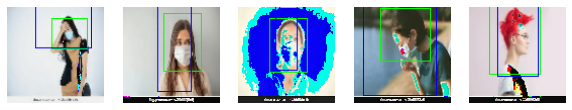

Actual = 0 , Predicted =  0
Actual = 0 , Predicted =  0
Actual = 0 , Predicted =  0
Actual = 0 , Predicted =  0
Actual = 1 , Predicted =  1

Val dataset:


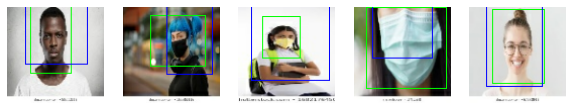

Actual = 1 , Predicted =  0
Actual = 0 , Predicted =  0
Actual = 0 , Predicted =  0
Actual = 0 , Predicted =  0
Actual = 1 , Predicted =  1
5/5 - 3s - loss: 0.5773 - classifier_loss: 0.1120 - localizer_loss: 0.4653 - classifier_acc: 0.9741 - localizer__localizer_metric: 0.5409 - val_loss: 0.8955 - val_classifier_loss: 0.3105 - val_localizer_loss: 0.5850 - val_classifier_acc: 0.8065 - val_localizer__localizer_metric: 0.4150
Epoch 21/100
5/5 - 1s - loss: 0.5810 - classifier_loss: 0.1069 - localizer_loss: 0.4741 - classifier_acc: 0.9815 - localizer__localizer_metric: 0.5279 - val_loss: 0.8552 - val_classifier_loss: 0.2935 - val_localizer_loss: 0.5617 - val_classifier_acc: 0.8065 - val_localizer__localizer_metric: 0.4383
Epoch 22/100
5/5 - 1s - loss: 0.5507 - classifier_loss: 0.0952 - localizer_loss: 0.4555 - classifier_acc: 0.9778 - localizer__localizer_metric: 0.5334 - val_loss: 0.8591 - val_classifier_loss: 0.2870 - val_localizer_loss: 0.5722 - val_classifier_acc: 0.8387 - val_localizer

In [ ]:
params = {
    'MASKED_FOLDER': '/content/yolo_format/mask_with_coodinate',
    'NORMAL_FOLDER': '/content/yolo_format/normal_with_coodinate',
    'TRAIN_VAL_RATIO': 0.9,
    'BATCH_SIZE': 64,

    'HUB_URL': 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/4',
    'IMG_SIZE': [96, 96],
    'SAVE_PATH': 'model.h5',
    
    'EPOCHS': 100
}

t = Train(params)
history = t.train()

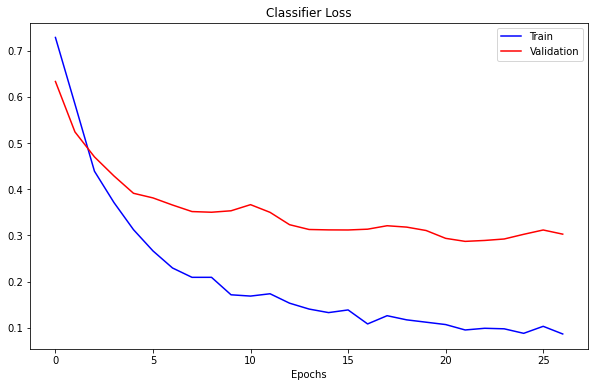

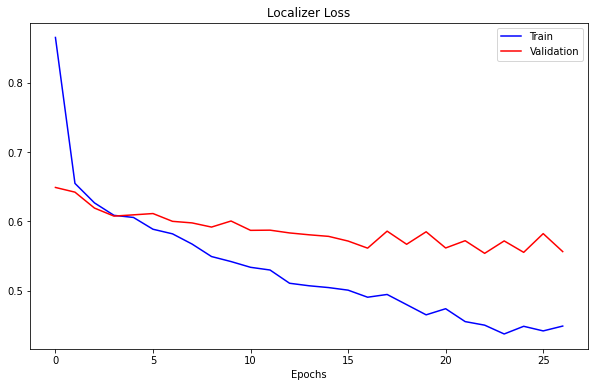

In [ ]:
epochs = len(history['classifier_loss'])
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), history['classifier_loss'], 'b-')
plt.plot(range(epochs), history['val_classifier_loss'], 'r-')
plt.title('Classifier Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), history['localizer_loss'], 'b-')
plt.plot(range(epochs), history['val_localizer_loss'], 'r-')
plt.title('Localizer Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()